Exploring the Arts Council National Portfolio 2018-2022

On 27 June 2017, the [Arts Council England](http://www.artscouncil.org.uk/) announced the [National Portfolio Organisations](http://www.artscouncil.org.uk/NPO) for the next four years. They also provided [a factsheet](http://www.artscouncil.org.uk/sites/default/files/download-file/Investment__factsheet.pdf) and [a dataset](http://www.artscouncil.org.uk/sites/default/files/download-file/NPO_successful_20182022_July_27.xlsx)! 

Now we've explored and had a stab at [tidying the dataset](https://github.com/ekoner/Arts-Council-National-Portfolio/blob/master/notebook/Arts%20Council%20National%20Portfolio%202018-2022.ipynb), it's time to revisit it systematically.

Author: Edafe Onerhime

Created: 2018-08-04

Last Updated: 2018-08-05

Description: Systematic exploration of the [original dataset](http://www.artscouncil.org.uk/sites/default/files/download-file/NPO_successful_20182022_July_27.xlsx) and the [tidy datasets](http://vita.had.co.nz/papers/tidy-data.pdf): [funding](https://github.com/ekoner/Arts-Council-National-Portfolio/blob/master/data/output/NPO_successful_20182022_July_6_funding.csv) & [portfolio](https://github.com/ekoner/Arts-Council-National-Portfolio/blob/master/data/output/NPO_successful_20182022_July_6_portfolio.csv).

Contents: Notebook folder with this Jupyter Notebook, data folder, research folder (not sync'd to GitHub)

Notes:

2018-08-05 - Changed direction with this notebook. Initially it was a loose exploration tool, now I'm using it to explore processes and artefacts that speed up systematic data analysis. This notebook will chop and change frequently!

In [1]:
%matplotlib inline

import os.path
import pandas as pd
import numpy as np
import missingno as msno

from IPython.core.display import display, HTML
from urllib.request import urlretrieve
from tabulate import tabulate

In [2]:
"""
    Making 'global' variables we'll re-use later easier to set
"""
originalFile = {'fname': 'NPO_successful_20182022_July_6.xlsx',
                'url': 'http://www.artscouncil.org.uk/sites/default/files/download-file/NPO_successful_20182022_July_6.xlsx'}

dataFolderOut = os.path.join(os.pardir,'data','output')
dataFolderIn = os.path.join(os.pardir,'data','input')

In [3]:
"""
    All the functions we'll need
"""

def customInfo(dfIn):
    """
        Summary text and table based on Dataframe.info()
    """
    
    df = dfIn.copy(deep=True)
    df.df_name = dfIn.df_name
    
    CI = 'The dataset ' + "'" + df.df_name + "'" + \
         ' has ' + str(df.shape[1]) + ' columns and ' + str(df.shape[0]) + ' rows. Columns: '
    s = df.get_dtype_counts()
    for ind, val in s.iteritems():
        CI = CI + str(val) + ' ' + ind +', '            
    CI = CI[:-2]+'.'

    dfCI = pd.DataFrame()
    df.reset_index(inplace=True)
    dfCI['count'] = df.count()
    dfCI['unique'] = df.T.apply(lambda x: x.nunique(), axis=1)
    dfCI['min'] = df.min()
    dfCI['max'] = df.max()
    dfCI['median'] = df.median()
    dfCI['range'] = dfCI['max'].apply(pd.to_numeric, errors='coerce') - dfCI['min'].apply(pd.to_numeric, errors='coerce')
    try:
        dfCI['iqr'] = df.quantile(0.75) - df.quantile(0.25)    
    except:
        dfCI['iqr'] = np.nan
    dfCI.sort_index(inplace=True)
    return dfCI, CI

def portfolioTransform(dfIn, ColumnName, Year, Period, Type):
    """ 
        Returns a dataframe with Portfolio Funding amount, Year e.g. 2015 and Period e.g. 2015-2018
    """
    df = dfIn[[ColumnName]].copy(deep=True)
    df['Year'] = Year
    df['Period'] = Period
    df['Type'] = Type
    df.rename(columns={ColumnName:'Amount'}, inplace=True)
    return df

def describeCategory(dfIn, measure=''):
    """
        Returns an array of dataframes showing count and proportion of each category
        (1 dataframe per category column)
        When a measure is provided, use the measure instead of the count
    """
    
    df = dfIn.copy(deep=True).reset_index()
    dataframes = []
    i = 0
    
    if len(measure)==0:
        for catCol in list(df.select_dtypes(include=['category']).columns):
            dataframes.append(pd.DataFrame(df[catCol].value_counts()).reset_index().rename(columns={catCol: 'Count', 'index': catCol}))
            dataframes[i]['%'] = dataframes[i][['Count']]/df.shape[0]
            dataframes[i].df_name = catCol
            i+= 1
    else:
        for catCol in list(df.select_dtypes(include=['category']).columns):
            dataframes.append(pd.DataFrame(df.reset_index().groupby(catCol)[measure].agg('sum').reset_index()))
            dataframes[i]['%'] = dataframes[i][[measure]]/df[measure].sum() 
            dataframes[i].df_name = catCol
            i+= 1
    return dataframes

In [4]:
"""
    Load datasets we'll use later
"""

# Fetch/Load Original
fname = os.path.join(dataFolderIn,originalFile['fname'])
if not os.path.isfile(fname):
    print('Downloading:',fname)
    url = originalFile['url']
    urlretrieve(url, fname)

df = pd.read_excel(open(fname,'rb'), sheetname=0)
df.df_name = 'Original'

"""
    Get summary information
"""
dfInfo, infoText = customInfo(df)

print(infoText)
dfInfo

The dataset 'Original' has 22 columns and 844 rows. Columns: 4 float64, 5 int64, 13 object.


,count,unique,min,max,median,range,iqr
% Cash change between 17/18 and 18/19,844,252,NaN,NaN,NaN,NaN,NaN
ACE Region,844,9,East,Yorkshire,NaN,NaN,NaN
Alternative Name,111,108,NaN,NaN,NaN,NaN,NaN
Applicant Name,844,831,NaN,NaN,NaN,NaN,NaN
Area,844,6,London,South West,NaN,NaN,NaN
Discipline,844,9,Combined arts,Visual arts,NaN,NaN,NaN
Funding Band,844,4,NaN,NaN,NaN,NaN,NaN
Funding Source (GIA or LOT),844,2,GIA,LOT,NaN,NaN,NaN
Local Authority,844,184,Allerdale,York,NaN,NaN,NaN
Notes,37,16,NaN,NaN,NaN,NaN,NaN


In [5]:
"""
    Tidy and enrich the original dataset
"""

# Strip out carriage returns in column names
df = df.rename(columns={col: col.replace('\n','').replace('  ',' ') for col in df.columns})
df.df_name = 'All'

# Strip out text value 'NEW' so column is all numbers
df.loc[df['% Cash change between 17/18 and 18/19'].str.contains('NEW', na=False), '% Cash change between 17/18 and 18/19'] = np.NaN

# Make these columns categories
catCols = ['Funding Band', 'Area', 'ACE Region', 'ONS Region', 'Discipline', 'Funding Source (GIA or LOT)']
df[catCols] = df[catCols].apply(pd.Categorical)

# Make this column true or false (Bool)
df.loc[df['Portfolio funded in 2015-18?'].str.contains('Yes', na=False), 'Portfolio funded in 2015-18?'] = True
df.loc[df['Portfolio funded in 2015-18?'].str.contains('No', na=False), 'Portfolio funded in 2015-18?'] = False
df['Portfolio funded in 2015-18?'] = df['Portfolio funded in 2015-18?'].astype('bool')

# Make these columns ints
intCols = ['Portfolio funding 15/16 - £', 'Portfolio funding 16/17 - £', 'Portfolio funding 17/18 - £', 
           'TOTAL Portfolio funding 15/18 - £']
df[intCols] = df[intCols].astype('int')

# Enrich: Funding Source (GIA or LOT) using descriptions here: https://www.artsprofessional.co.uk/news/npo-scheme-merge-ace-grant-aid-and-lottery-funding
df['Funding Source Description'] = df['Funding Source (GIA or LOT)'].astype(str)
df.loc[df['Funding Source Description'].str.contains('GIA', na=False), 'Funding Source Description'] = 'Grant in Aid'
df.loc[df['Funding Source Description'].str.contains('LOT', na=False), 'Funding Source Description'] = 'National Lottery'

# Enrich: Funding Bands using descriptions here: http://www.artscouncil.org.uk/sites/default/files/download-file/Briefing_current_NPOs_MPMs_FINAL.pptx
df['Funding Band Description'] = df['Funding Band'].astype(str)
df.loc[~df['Funding Band Description'].str.contains('SSO'), 'Funding Band Description'] = 'Band ' + df['Funding Band Description'].astype(str)
df.loc[df['Funding Band Description'].str.contains('SSO'), 'Funding Band Description'] = 'Sector Support Organisation'

# Pull information out of notes: Bridge Organisation, Uplift, Reduction, Museum Development
df['Bridge Organisation'] = False
df['Technical Uplift'] = False
df['Technical Reduction'] = False
df['Museum Development'] = False
df.loc[df['Notes'].str.lower().str.contains('bridge organisation', na=False), 'Bridge Organisation'] = True
df.loc[df['Notes'].str.lower().str.contains('uplift', na=False), 'Technical Uplift'] = True
df.loc[df['Notes'].str.lower().str.contains('reduction', na=False), 'Technical Reduction'] = True
df.loc[df['Notes'].str.lower().str.contains('museum development', na=False), 'Museum Development'] = True

# Add Index (Looks like Applicant Name & Funding Band are unique)
df.set_index(['Applicant Name', 'Funding Band'], inplace=True)

"""
    Split into Applicant, Classification, Portfolio and save as csv
"""

dfApplicant = df[['Alternative Name', 'Web address', 'Discipline', 'Notes', 'Area', 'ACE Region', 'ONS Region', 'Local Authority']]
dfApplicant.df_name = 'Applicant'

dfClassification = df[['Funding Source (GIA or LOT)', 'Funding Source Description', 'Funding Band Description', 'Portfolio funded in 2015-18?', 'Bridge Organisation', 'Technical Uplift', 'Technical Reduction', 'Museum Development']]
dfClassification.df_name = 'Classification'

dfPortfolio = portfolioTransform(df,'Portfolio funding 15/16 - £','2015','2015-2018','Fund')
dfPortfolio = dfPortfolio.append(portfolioTransform(df,'Portfolio funding 16/17 - £','2016','2015-2018','Fund'))
dfPortfolio = dfPortfolio.append(portfolioTransform(df,'Portfolio funding 17/18 - £','2017','2015-2018','Fund'))
dfPortfolio = dfPortfolio.append(portfolioTransform(df,'Portfolio grant 18/19 - £','2018','2018-2022','Grant'))
dfPortfolio = dfPortfolio.append(portfolioTransform(df,'Portfolio grant 19/20 - £','2019','2018-2022','Grant'))
dfPortfolio = dfPortfolio.append(portfolioTransform(df,'Portfolio grant 20/21 - £','2020','2018-2022','Grant'))
dfPortfolio = dfPortfolio.append(portfolioTransform(df,'Portfolio grant 21/22 - £','2021','2018-2022','Grant'))

# Make Period, Type categories then add Year to index
catCols = ['Year','Period','Type']
dfPortfolio[catCols] = dfPortfolio[catCols].apply(pd.Categorical)
dfPortfolio.set_index('Year', append=True, inplace=True)
dfPortfolio.df_name = 'Portfolio'

# Save csv
filePrefix = 'NPO_2018-22_'
df.to_csv(os.path.join(dataFolderOut,filePrefix+'all.csv'))
dfApplicant.to_csv(os.path.join(dataFolderOut,filePrefix+'applicant.csv'))
dfPortfolio.to_csv(os.path.join(dataFolderOut,filePrefix+'portfolio.csv'))
dfClassification.to_csv(os.path.join(dataFolderOut,filePrefix+'classification.csv'))

In [6]:
"""
    Get summary information
"""
dfInfo, infoText = customInfo(df)
print(infoText)
dfInfo, infoText = customInfo(dfApplicant)
print(infoText)
dfInfo, infoText = customInfo(dfPortfolio)
print(infoText)
dfInfo, infoText = customInfo(dfClassification)
print(infoText)


The dataset 'All' has 26 columns and 844 rows. Columns: 5 bool, 5 category, 9 int64, 7 object.
The dataset 'Applicant' has 8 columns and 844 rows. Columns: 4 category, 4 object.
The dataset 'Portfolio' has 3 columns and 5908 rows. Columns: 2 category, 1 int64.
The dataset 'Classification' has 8 columns and 844 rows. Columns: 5 bool, 1 category, 2 object.


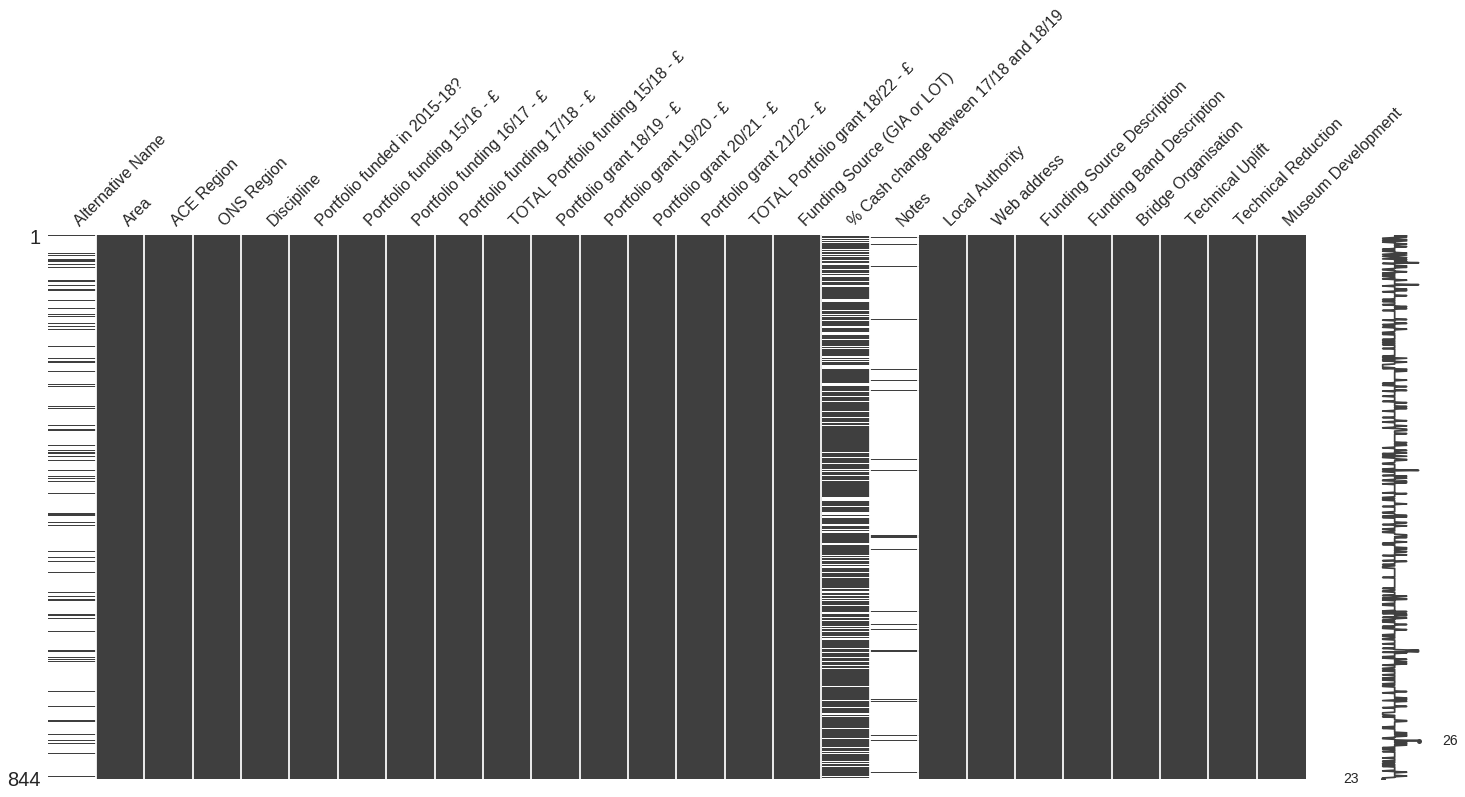

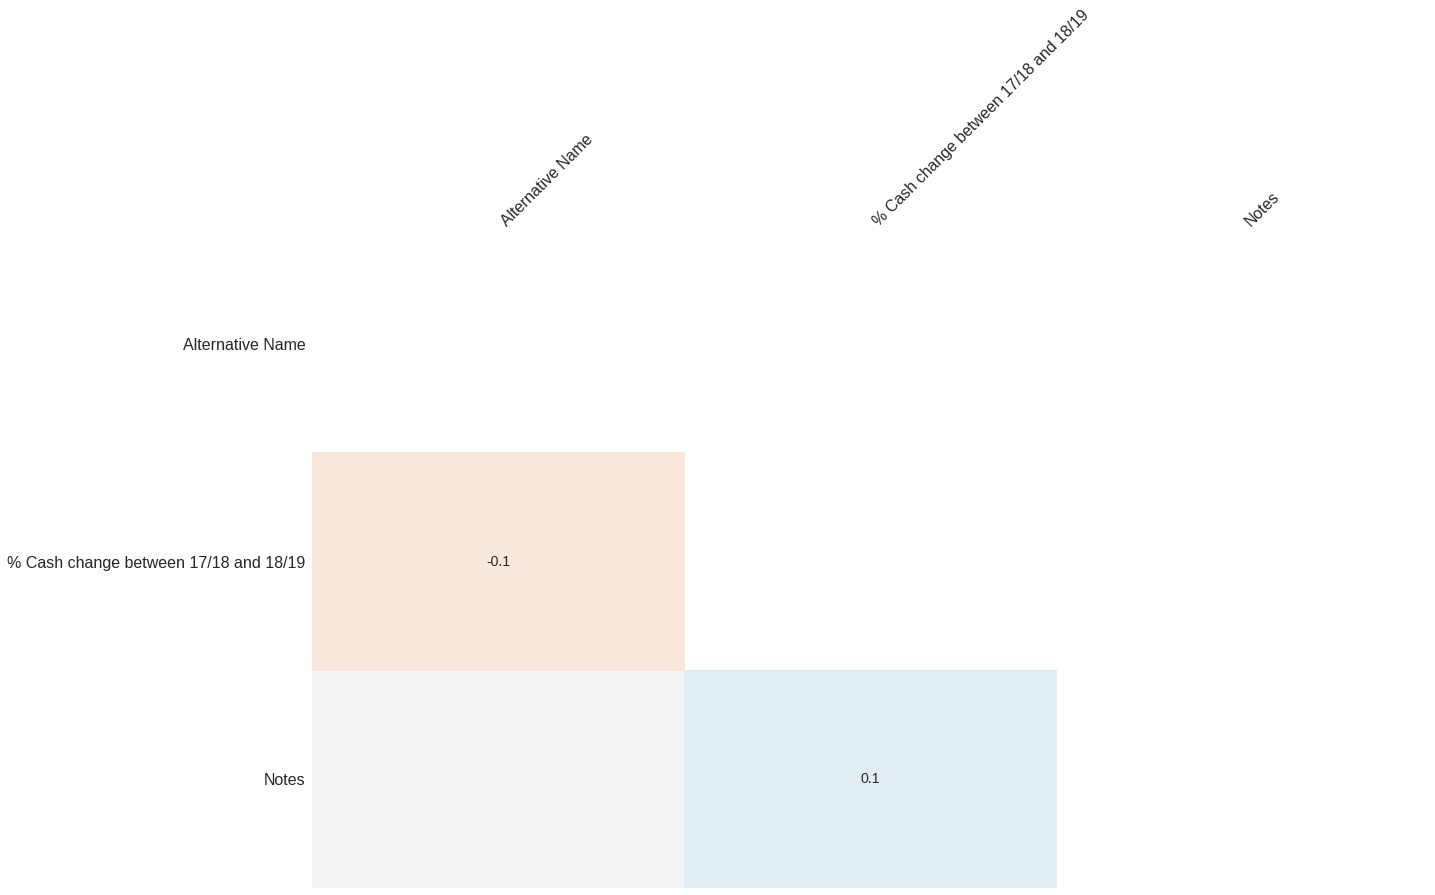

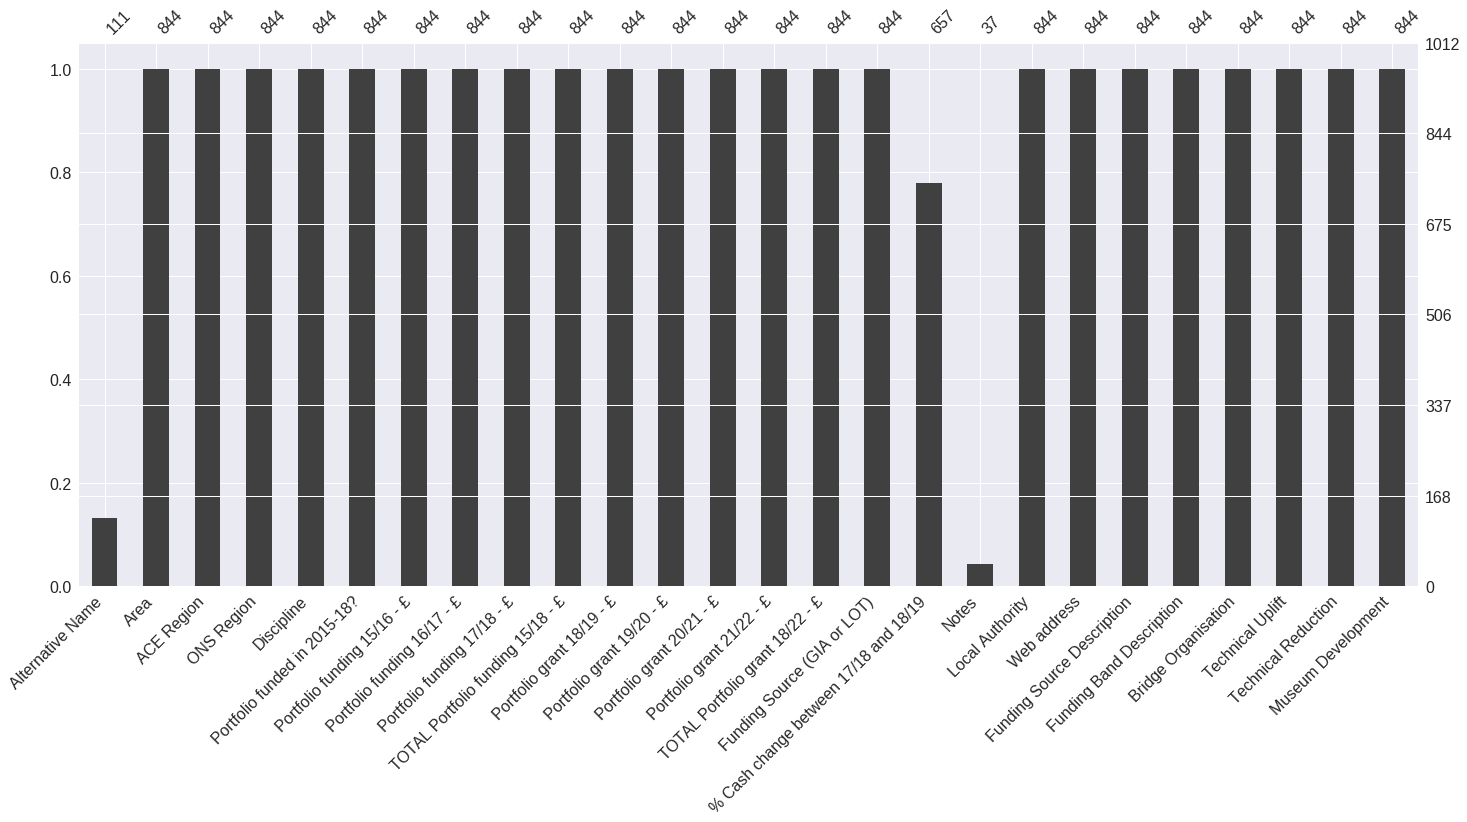

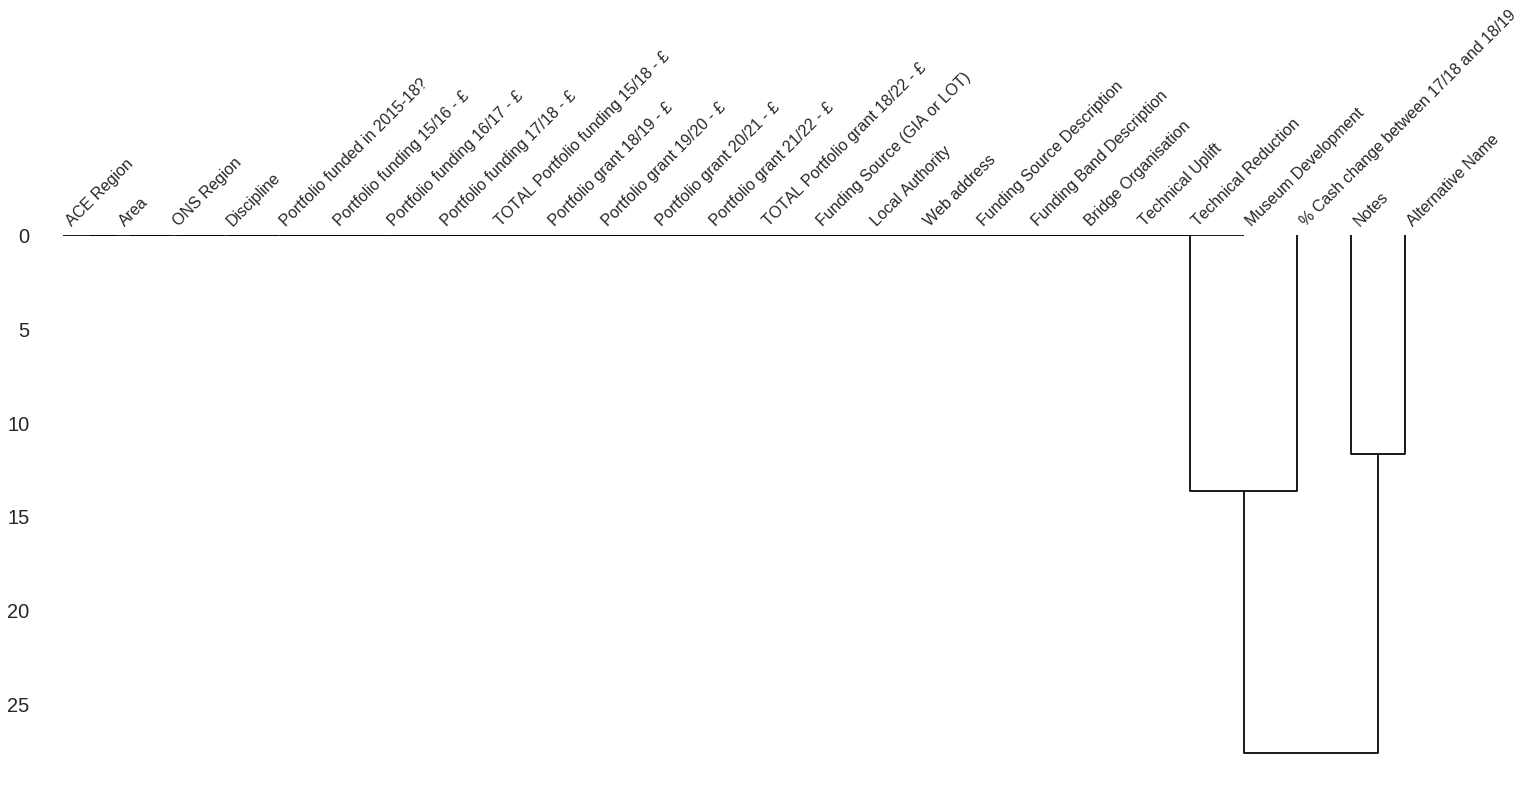

In [7]:
"""
    Landscape: Check for missing values using MissingNo
    https://github.com/ResidentMario/missingno
"""

msno.matrix(df)
msno.heatmap(df)
msno.bar(df)
msno.dendrogram(df)

In [8]:
print('\n', 'Applicant')
lstDesc = describeCategory(dfApplicant)
for dfDesc in lstDesc:
    print('\n',dfDesc.df_name)
    display(HTML(tabulate(dfDesc,headers='keys', tablefmt='html', showindex=False, )))
    
print('\n', 'Portfolio')
lstDesc = describeCategory(dfPortfolio)
for dfDesc in lstDesc:
    print('\n',dfDesc.df_name)
    display(HTML(tabulate(dfDesc,headers='keys', tablefmt='html', showindex=False, )))    

print('\n', 'Classification')
lstDesc = describeCategory(dfClassification)
for dfDesc in lstDesc:
    print('\n',dfDesc.df_name)
    display(HTML(tabulate(dfDesc,headers='keys', tablefmt='html', showindex=False, )))


 Applicant

 Funding Band


Funding Band,Count,%
1,530,0.627962
2,190,0.225118
3,66,0.0781991
SSO,58,0.0687204



 Discipline


Discipline,Count,%
Theatre,190,0.225118
Combined arts,187,0.221564
Visual arts,149,0.17654
Music,102,0.120853
Museums,72,0.0853081
Dance,64,0.0758294
Literature,49,0.0580569
Not discipline specific,24,0.028436
Libraries,7,0.00829384



 Area


Area,Count,%
London,253,0.299763
North,225,0.266588
Midlands,129,0.152844
South West,103,0.122038
South East,100,0.118483
National,34,0.0402844



 ACE Region


ACE Region,Count,%
London,268,0.317536
South West,104,0.123223
North West,94,0.111374
Yorkshire,93,0.11019
West Midlands,76,0.0900474
South East,57,0.0675355
East Midlands,56,0.0663507
North East,48,0.056872
East,48,0.056872



 ONS Region


ONS Region,Count,%
London,268,0.317536
North West,94,0.111374
Yorkshire and The Humber,93,0.11019
South West,86,0.101896
South East,74,0.0876777
West Midlands,73,0.0864929
East Midlands,56,0.0663507
North East,48,0.056872
East of England,48,0.056872
WALES,4,0.00473934



 Portfolio

 Funding Band


Funding Band,Count,%
1,3710,0.627962
2,1330,0.225118
3,462,0.0781991
SSO,406,0.0687204



 Year


Year,Count,%
2021,844,0.142857
2020,844,0.142857
2019,844,0.142857
2018,844,0.142857
2017,844,0.142857
2016,844,0.142857
2015,844,0.142857



 Period


Period,Count,%
2018-2022,3376,0.571429
2015-2018,2532,0.428571



 Type


Type,Count,%
Grant,3376,0.571429
Fund,2532,0.428571



 Classification

 Funding Band


Funding Band,Count,%
1,530,0.627962
2,190,0.225118
3,66,0.0781991
SSO,58,0.0687204



 Funding Source (GIA or LOT)


Funding Source (GIA or LOT),Count,%
GIA,694,0.822275
LOT,150,0.177725


In [9]:
print('\n', 'Portfolio')
lstDesc = describeCategory(dfPortfolio,'Amount')
for dfDesc in lstDesc:
    print('\n',dfDesc.df_name)
    display(HTML(tabulate(dfDesc,headers='keys', tablefmt='html', showindex=False, )))    



 Portfolio

 Funding Band


Funding Band,Amount,%
1,422929045,0.155876
2,633424839,0.233457
3,1520734544,0.560485
SSO,136157170,0.0501824



 Year


Year,Amount,%
2015,360013986,0.132688
2016,360013986,0.132688
2017,360153986,0.132739
2018,407638276,0.15024
2019,408568678,0.150583
2020,408388276,0.150517
2021,408468410,0.150546



 Period


Period,Amount,%
2015-2018,1080181958,0.398114
2018-2022,1633063640,0.601886



 Type


Type,Amount,%
Fund,1080181958,0.398114
Grant,1633063640,0.601886
